# Weapon Damage Per Turn

## Setting Up

In [1]:
import pandas as pd
from weapon import max_shots, burst

weapon_stats = pd.read_csv("datasets/weapon_stats.csv")
ammo_stats = pd.read_csv("datasets/ammo_stats.csv")
weapon_firemodes = pd.read_csv("datasets/weapon_firemodes.csv")
damage_modifiers = pd.read_csv("datasets/damage_modifiers.csv")

## Data Merge

In [2]:
weapon_attacks = weapon_stats.merge(ammo_stats, on="weapon")
weapon_attacks = weapon_attacks.merge(weapon_firemodes, on="weapon")
weapon_attacks = weapon_attacks.sort_values(by=["weapon", "fire_mode"])
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32


## Chance to Hit

Soldiers start with an Accuracy value between 40 and 70, giving an average of 55.

To get the change of hit this should by applied to the weapon accuracy. Just multiply them as proportions. So an average of 55 to a weapon of Accuracy 90 means 0.55 * 0.9 = 0.495 chance of hit.

In [3]:
weapon_attacks["chance_to_hit"] = weapon_attacks.apply(lambda x: x["accuracy"] / 100 * 0.55, axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760


## Derived Damage

In [4]:
# weapon_attacks = weapon_attacks.apply(burst, axis=1)
weapon_attacks["burst"] = weapon_attacks.apply(burst, axis=1)
weapon_attacks["turn_max_shots"] = weapon_attacks.apply(max_shots, axis=1)
weapon_attacks["turn_damage_max"] = weapon_attacks.apply(lambda x: x["turn_max_shots"] * x["damage"], axis=1)
weapon_attacks["turn_damage_expected"] = weapon_attacks.apply(lambda x: x["turn_damage_max"] * x["chance_to_hit"], axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,turn_max_shots,turn_damage_max,turn_damage_expected
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,1,1,90,32.175
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,1,1,42,18.942
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,1,1,44,19.844
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,1,1,48,21.648
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,3,6,252,44.352


## Damage Ranking

### Most Damaging Weapon

In a single turn, shooting as much as possible, which weapon does the most damage.

This takes into account reloading.

In [5]:
most_damaging_weapon_average = weapon_attacks[["weapon", "turn_damage_expected"]]
most_damaging_weapon_average = most_damaging_weapon_average.groupby("weapon").mean()

In [6]:
most_damaging_weapon_max = weapon_attacks[["weapon", "turn_damage_expected"]]
most_damaging_weapon_max = most_damaging_weapon_max.groupby("weapon").max()

In [7]:
most_damaging_weapon = most_damaging_weapon_max.merge(most_damaging_weapon_average, on="weapon")
most_damaging_weapon = most_damaging_weapon.rename(columns={"turn_damage_expected_x": "max", "turn_damage_expected_y": "average"})
most_damaging_weapon = most_damaging_weapon.sort_values(by=["average"])
most_damaging_weapon

,max,average
weapon,,
grenade,17.8750,17.875000
proximity_grenade,25.0250,25.025000
rifle,39.6000,30.800000
alien_grenade,32.1750,32.175000
auto_cannon,50.6880,36.194889
pistol,42.9000,38.181000
high_explosive,39.3250,39.325000
rocket_launcher,63.2500,41.295833
heavy_cannon,59.4000,41.580000


Text(0, 0.5, 'Damage')

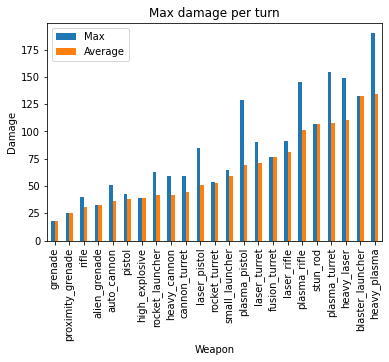

In [8]:
ax = most_damaging_weapon.plot.bar(title="Max damage per turn", legend=False)
ax.legend(["Max", "Average"])
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Most Damaging Snapshot

In [9]:
most_damaging_weapon_snap_average = weapon_attacks[weapon_attacks["fire_mode"] == "snapshot"]
most_damaging_weapon_snap_average = most_damaging_weapon_snap_average[["weapon", "turn_damage_expected"]]
most_damaging_weapon_snap_average = most_damaging_weapon_snap_average.groupby("weapon").mean()

In [10]:
most_damaging_weapon_snap_max = weapon_attacks[weapon_attacks["fire_mode"] == "snapshot"]
most_damaging_weapon_snap_max = most_damaging_weapon_snap_max[["weapon", "turn_damage_expected"]]
most_damaging_weapon_snap_max = most_damaging_weapon_snap_max.groupby("weapon").max()

In [11]:
most_damaging_weapon_snap = most_damaging_weapon_snap_max.merge(most_damaging_weapon_snap_average, on="weapon")
most_damaging_weapon_snap = most_damaging_weapon_snap.rename(columns={"turn_damage_expected_x": "max", "turn_damage_expected_y": "average"})
most_damaging_weapon_snap = most_damaging_weapon_snap.sort_values(by=["average"])
most_damaging_weapon_snap

,max,average
weapon,,
rocket_launcher,30.2500,26.720833
rifle,39.6000,39.600000
auto_cannon,44.3520,41.272000
pistol,42.9000,42.900000
laser_pistol,50.6000,50.600000
laser_turret,51.4250,51.425000
rocket_turret,51.4250,51.425000
heavy_cannon,59.4000,55.440000
plasma_pistol,55.7700,55.770000


Text(0, 0.5, 'Damage')

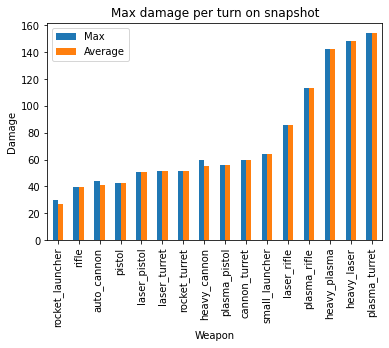

In [12]:
ax = most_damaging_weapon_snap.plot.bar(title="Max damage per turn on snapshot", legend=False)
ax.legend(["Max", "Average"])
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Most Damaging Aimed

In [13]:
most_damaging_weapon_aim_average = weapon_attacks[weapon_attacks["fire_mode"] == "aimed"]
most_damaging_weapon_aim_average = most_damaging_weapon_aim_average[["weapon", "turn_damage_expected"]]
most_damaging_weapon_aim_average = most_damaging_weapon_aim_average.groupby("weapon").mean()

In [14]:
most_damaging_weapon_aim_max = weapon_attacks[weapon_attacks["fire_mode"] == "aimed"]
most_damaging_weapon_aim_max = most_damaging_weapon_aim_max[["weapon", "turn_damage_expected"]]
most_damaging_weapon_aim_max = most_damaging_weapon_aim_max.groupby("weapon").max()

In [15]:
most_damaging_weapon_aim = most_damaging_weapon_aim_max.merge(most_damaging_weapon_aim_average, on="weapon")
most_damaging_weapon_aim = most_damaging_weapon_aim.rename(columns={"turn_damage_expected_x": "max", "turn_damage_expected_y": "average"})
most_damaging_weapon_aim = most_damaging_weapon_aim.sort_values(by=["average"])
most_damaging_weapon_aim

,max,average
weapon,,
laser_pistol,17.2040,17.204000
rifle,18.1500,18.150000
auto_cannon,21.6480,20.144667
plasma_pistol,24.3100,24.310000
heavy_cannon,29.7000,27.720000
cannon_turret,29.7000,29.700000
pistol,33.4620,33.462000
plasma_rifle,44.0000,44.000000
rocket_turret,53.7625,53.762500


Text(0, 0.5, 'Damage')

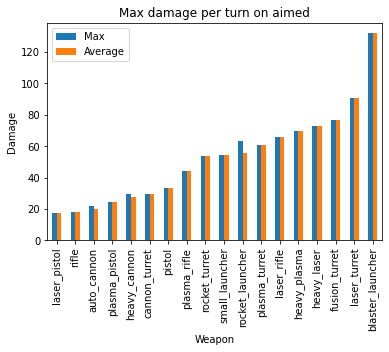

In [16]:
ax = most_damaging_weapon_aim.plot.bar(title="Max damage per turn on aimed", legend=False)
ax.legend(["Max", "Average"])
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Most Damaging Auto

In [17]:
most_damaging_weapon_auto_average = weapon_attacks[weapon_attacks["fire_mode"] == "auto"]
most_damaging_weapon_auto_average = most_damaging_weapon_auto_average[["weapon", "turn_damage_expected"]]
most_damaging_weapon_auto_average = most_damaging_weapon_auto_average.groupby("weapon").mean()

In [18]:
most_damaging_weapon_auto_max = weapon_attacks[weapon_attacks["fire_mode"] == "auto"]
most_damaging_weapon_auto_max = most_damaging_weapon_auto_max[["weapon", "turn_damage_expected"]]
most_damaging_weapon_auto_max = most_damaging_weapon_auto_max.groupby("weapon").max()

In [19]:
most_damaging_weapon_auto = most_damaging_weapon_auto_max.merge(most_damaging_weapon_auto_average, on="weapon")
most_damaging_weapon_auto = most_damaging_weapon_auto.rename(columns={"turn_damage_expected_x": "max", "turn_damage_expected_y": "average"})
most_damaging_weapon_auto = most_damaging_weapon_auto.sort_values(by=["average"])
most_damaging_weapon_auto

,max,average
weapon,,
rifle,34.650,34.650
auto_cannon,50.688,47.168
laser_pistol,85.008,85.008
laser_rifle,91.080,91.080
plasma_pistol,128.700,128.700
plasma_rifle,145.200,145.200
heavy_plasma,189.750,189.750


Text(0, 0.5, 'Damage')

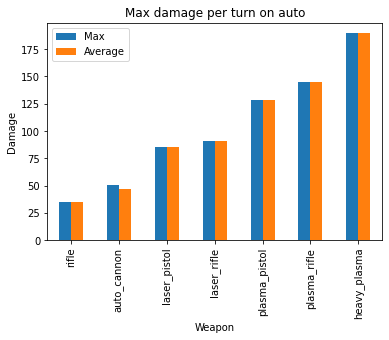

In [20]:
ax = most_damaging_weapon_auto.plot.bar(title="Max damage per turn on auto", legend=False)
ax.legend(["Max", "Average"])
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Most Damaging Grenade

In [21]:
most_damaging_weapon_grenade = weapon_attacks[weapon_attacks["fire_mode"] == "grenade"]
most_damaging_weapon_grenade = most_damaging_weapon_grenade[["weapon", "turn_damage_expected"]]
most_damaging_weapon_grenade = most_damaging_weapon_grenade.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_grenade = most_damaging_weapon_grenade.set_index(["weapon"])
most_damaging_weapon_grenade = most_damaging_weapon_grenade.sort_values(by=["turn_damage"])
most_damaging_weapon_grenade

,turn_damage
weapon,
grenade,17.875
proximity_grenade,25.025
alien_grenade,32.175
high_explosive,39.325


Text(0, 0.5, 'Damage')

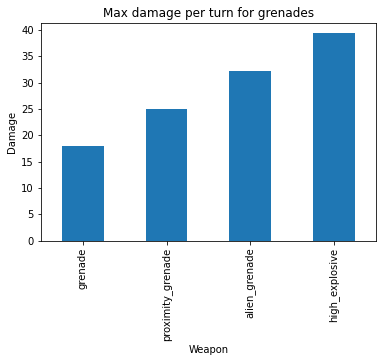

In [22]:
ax = most_damaging_weapon_grenade.plot.bar(title="Max damage per turn for grenades", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")